# Time-Series Analysis of Weather Data (2000-2023)


## By: José Donado


The contiguous notebook show the process and results of a weather forecast using a Kaggle dataset for the country of Mexico, analogous to Guatemala.


### Libraries



In [1]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install xgboost


In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Machine learning
import xgboost as xgb



### Datasets


In [51]:
df = pd.read_csv("Mexico_weather_data.csv")
#Set index: datetime
# 2. Convert column to datetime objects
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
df = df.set_index('Date')
df.index

DatetimeIndex(['2000-01-01', '2000-01-02', '2000-01-03', '2000-01-04',
               '2000-01-05', '2000-01-06', '2000-01-07', '2000-01-08',
               '2000-01-09', '2000-01-10',
               ...
               '2023-12-22', '2023-12-23', '2023-12-24', '2023-12-25',
               '2023-12-26', '2023-12-27', '2023-12-28', '2023-12-29',
               '2023-12-30', '2023-12-31'],
              dtype='datetime64[ns]', name='Date', length=8766, freq=None)

In [39]:
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [36]:
df.tail()

,Country,Temp_Max,Temp_Min,Temp_Mean,Precipitation_Sum,Windspeed_Max,Windgusts_Max,Sunshine_Duration,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Date,,,,,,,,,,,,,,,
2023-12-27,Mexico,16.4,2.9,9.6,0.0,19.8,34.2,35275.02,2,4,12,2023,361,27,52
2023-12-28,Mexico,17.4,0.9,8.4,0.0,12.3,19.8,35310.24,3,4,12,2023,362,28,52
2023-12-29,Mexico,13.9,0.8,7.1,0.0,16.0,28.4,35346.49,4,4,12,2023,363,29,52
2023-12-30,Mexico,16.3,-1.6,6.7,0.0,11.8,19.4,35353.05,5,4,12,2023,364,30,52
2023-12-31,Mexico,19.7,1.4,10.2,0.0,15.0,30.2,34202.77,6,4,12,2023,365,31,52


## Exploratory Analysis


In [6]:
#Select numeric values
numeric_cols = df.select_dtypes(include=[np.number]).columns
df_numeric = df[numeric_cols]

#### Correlations between variables


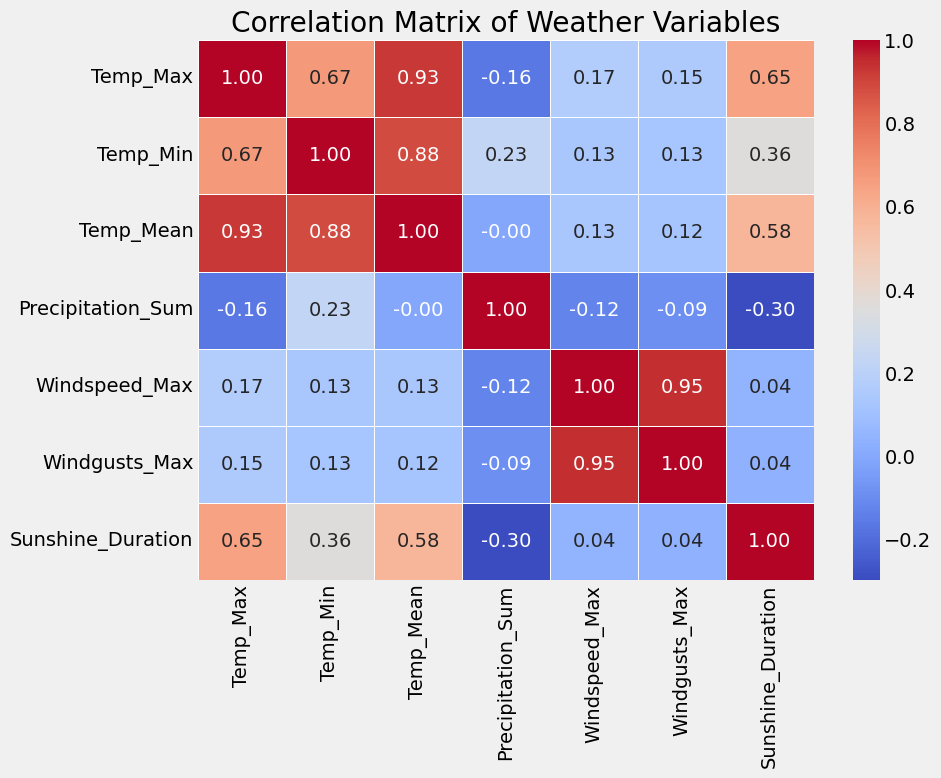

In [7]:

plt.figure(figsize=(10, 8))
# Compute correlation
corr_matrix = df_numeric.corr()
# Plot heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of Weather Variables')
plt.tight_layout()
plt.show()

Relevant direct relations are: temperature max & mean with sunshine duration (sense because the more time there is cloud-free radiation, the more heat the surface will recieve); precipitation with temp min. And, evidently, wind gusts correlate with windspeed max since this maximums are affected by a gust of wind.


Relevant inverse relations: precipitation vs. sunshine duration, precipitation vs. max temperature.

#### Mean, mode, median and std. dev. of each numeric variable
    

In [8]:
print("--- Summary Statistics ---")
stats_df = pd.DataFrame({
    'Mean': df_numeric.mean(),
    'Median': df_numeric.median(),
    # Mode can return multiple values, so we take the first one (iloc[0])
    'Mode': df_numeric.mode().iloc[0],
    'Standard Deviation': df_numeric.std()
})
print(stats_df)
print("\n")

print(37.893235-10.060492, 37.893235+10.060492)

--- Summary Statistics ---
                           Mean     Median     Mode  Standard Deviation
Temp_Max              25.204529     25.300     25.9            4.074677
Temp_Min              11.081120     12.000     14.6            4.224054
Temp_Mean             17.948585     18.500     18.2            3.982847
Precipitation_Sum      1.097935      0.000      0.0            3.292093
Windspeed_Max         20.547057     19.900     17.1            6.332958
Windgusts_Max         37.893235     36.400     34.2           10.060492
Sunshine_Duration  38498.262365  39268.625  36000.0         6268.043750


27.832742999999997 47.953727


All of them have a similar std. dev, and a relatively small skewness. The variable windgusts_max has a greater deviation, meaning that around 68% of windgusts vary between 27.83 and 47.95 m/s.

On the other hand, precipitation sum has the greater relative variation, and most of the precipitation tensd to be 0, but there are some days in wich it is greater than 1.


## Graphs

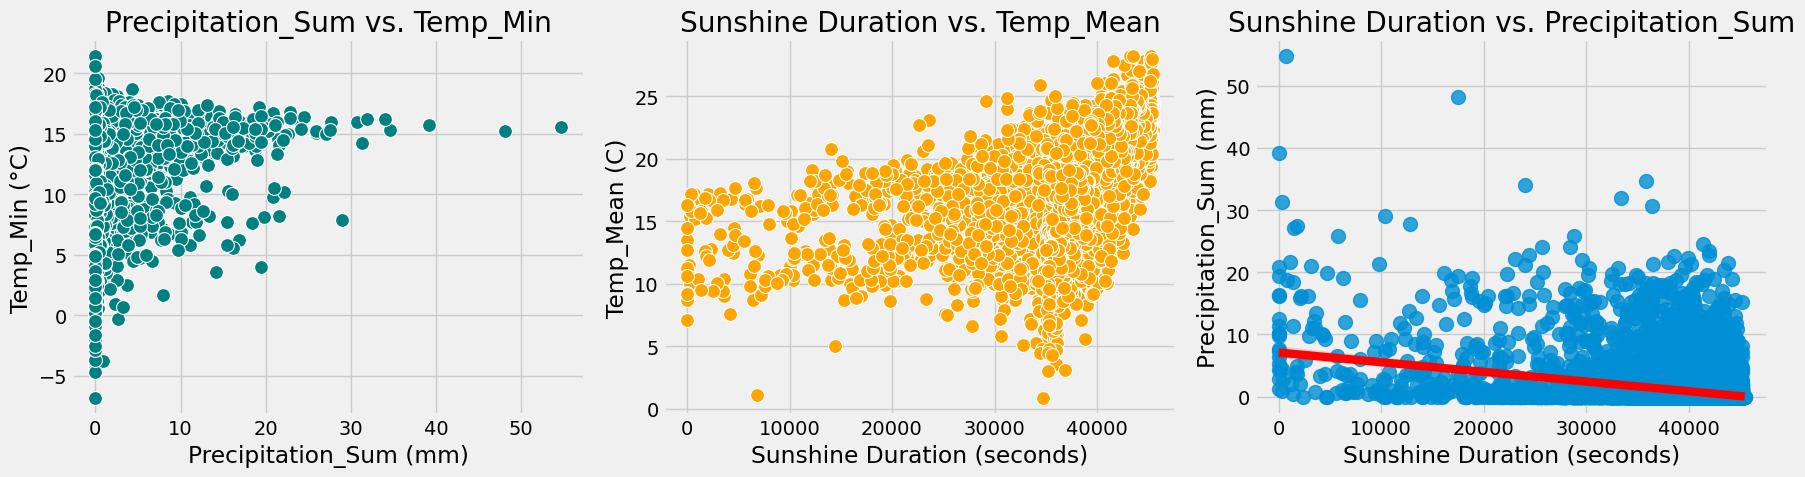

In [9]:
#grid of plots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Graph A: Wind Speed vs Temperature
# Hypothesis: Does higher wind speed correlate with lower mean temperature (cooling)?
sns.scatterplot(data=df, x='Precipitation_Sum', y='Temp_Min', ax=axes[0], color='teal', s=100)
axes[0].set_title('Precipitation_Sum vs. Temp_Min')
axes[0].set_xlabel('Precipitation_Sum (mm)')
axes[0].set_ylabel('Temp_Min (°C)')

# Graph B: Sunshine Duration vs TempMAX
# Hypothesis: Inverse relationship (more rain = less sun)
sns.scatterplot(data=df, x='Sunshine_Duration', y='Temp_Mean', ax=axes[1], color='orange', s=100)
axes[1].set_title('Sunshine Duration vs. Temp_Mean')
axes[1].set_xlabel('Sunshine Duration (seconds)')
axes[1].set_ylabel('Temp_Mean (C)')

# Graph C: Wind Gusts vs Sunshine
# Hypothesis: Is it windier on sunny days or cloudy days?
sns.regplot(data=df, x='Sunshine_Duration', y='Precipitation_Sum', ax=axes[2], scatter_kws={'s':100}, line_kws={'color':'red'})
axes[2].set_title('Sunshine Duration vs. Precipitation_Sum')
axes[2].set_xlabel('Sunshine Duration (seconds)')
axes[2].set_ylabel('Precipitation_Sum (mm)')

plt.tight_layout()
plt.show()

This confirms there is a relation with the exposed variables.

### Plot time series

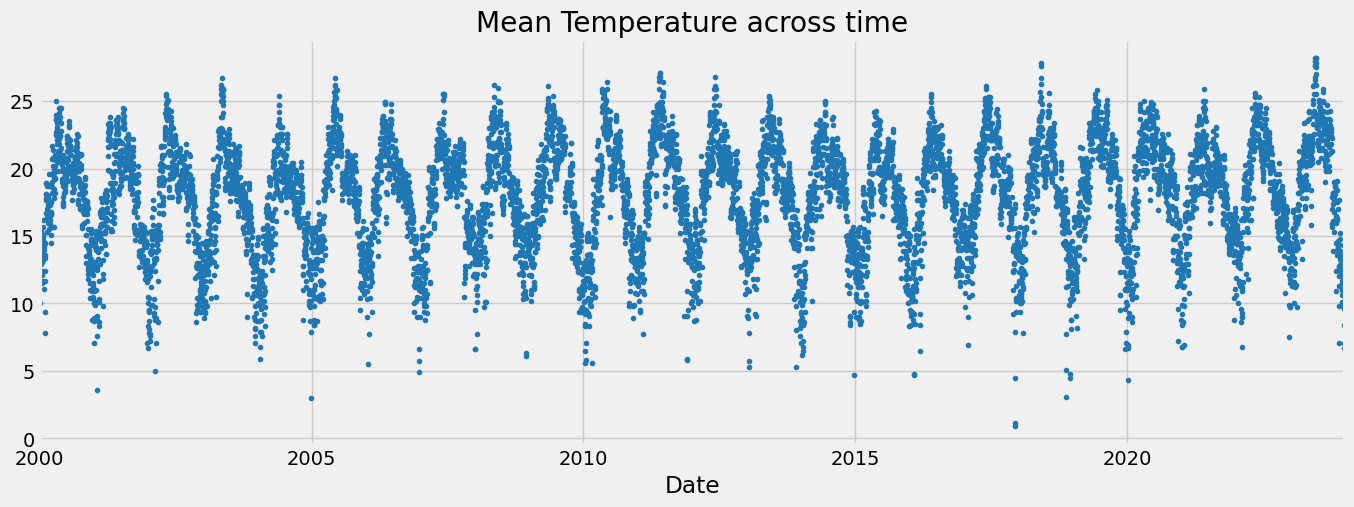

In [10]:
df["Temp_Mean"].plot(style='.', figsize= (15, 5), color = color_pal[0], title ='Mean Temperature across time')
plt.show()

# Train / Test Split

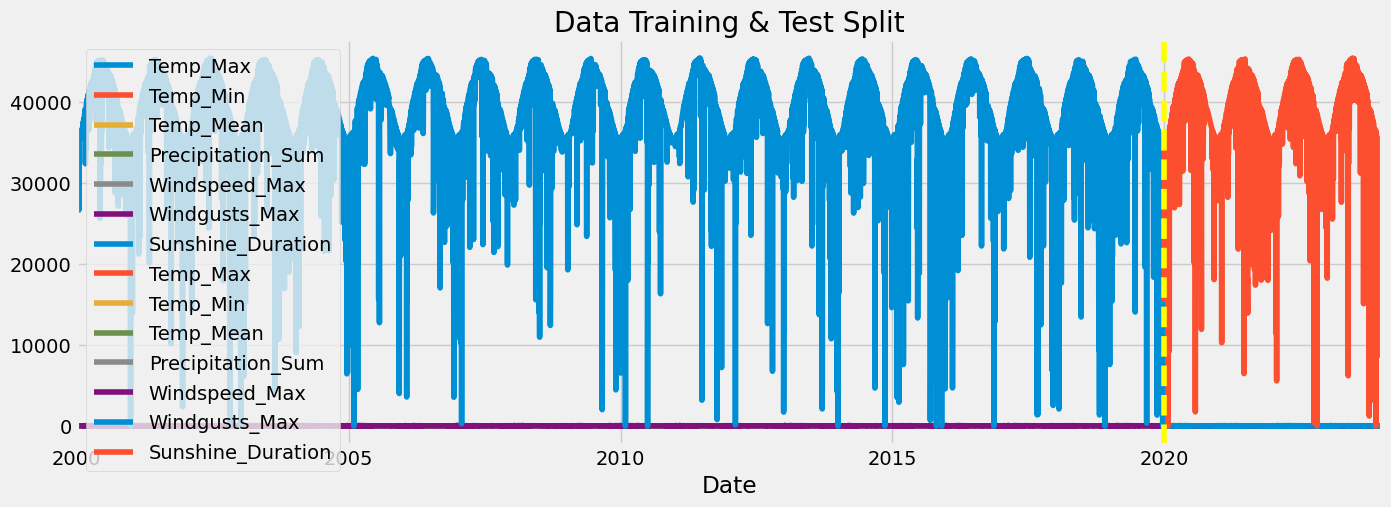

In [52]:
train = df.loc[df.index < '01-01-2020']
test = df.loc[df.index >= '01-01-2020']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label = 'Training Set', title = 'Data Training & Test Split')
test.plot(ax=ax, label = 'Test Set')
#division
ax.axvline('01-01-2020', color='yellow', ls='--')

plt.show()

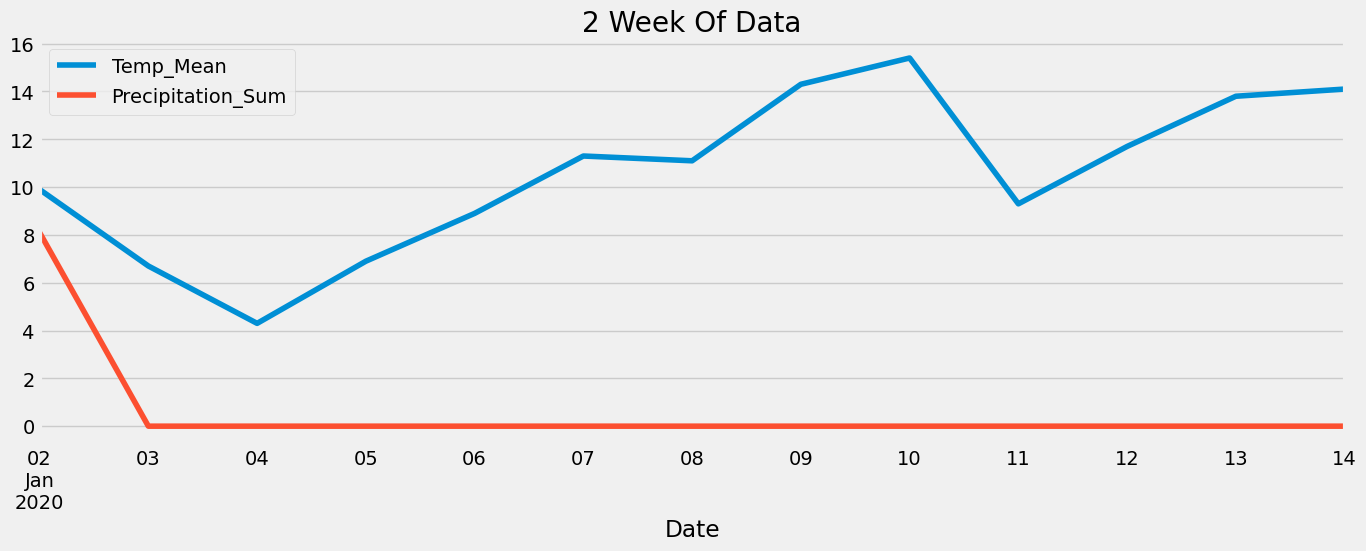

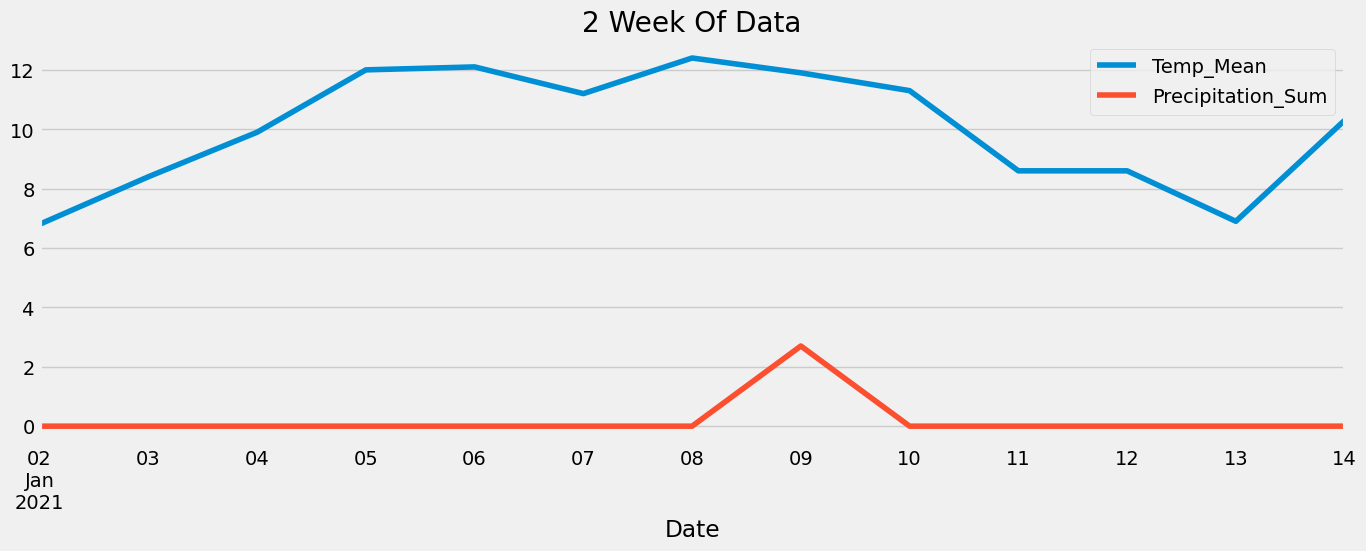

In [53]:
df[['Temp_Mean', 'Precipitation_Sum']].loc[(df.index > '01-01-2020') & (df.index < '01-15-2020')] \
    .plot(figsize=(15, 5), title='2 Week Of Data')
plt.show()

df[['Temp_Mean', 'Precipitation_Sum']].loc[(df.index > '01-01-2021') & (df.index < '01-15-2021')] \
    .plot(figsize=(15, 5), title='2 Week Of Data')
plt.show()



When two weeks from contiguous years compare it is noted that the temperature varies shallowly, just as the precipitation.

### Visualization of a month of 

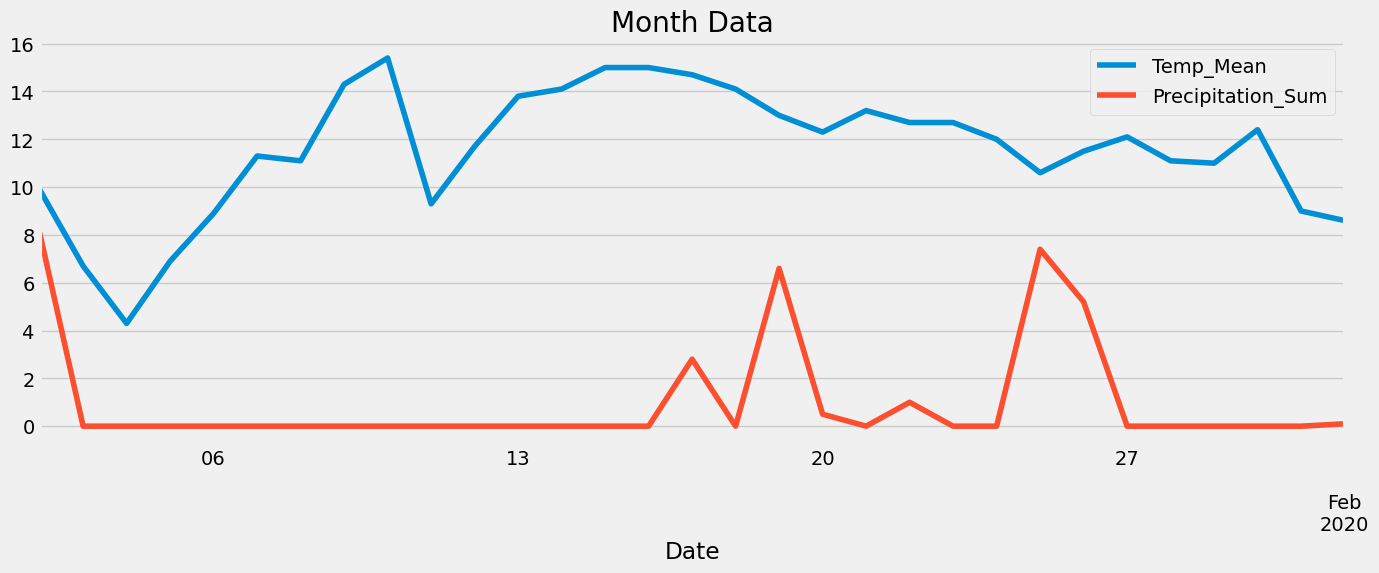

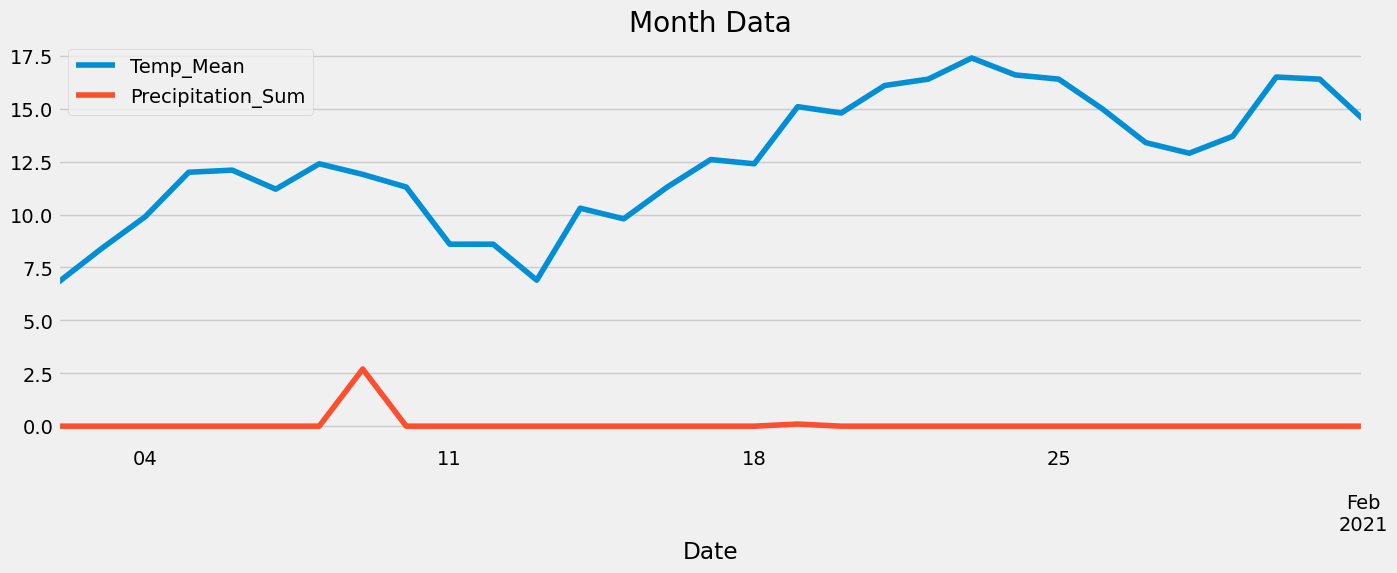

In [54]:
df[['Temp_Mean', 'Precipitation_Sum']].loc[(df.index > '01-01-2020') & (df.index < '02-02-2020')] \
    .plot(figsize=(15, 5), title='Month Data')
plt.show()

df[['Temp_Mean', 'Precipitation_Sum']].loc[(df.index > '01-01-2021') & (df.index < '02-02-2021')] \
    .plot(figsize=(15, 5), title='Month Data')
plt.show()

The temp pattern is similar, but the 2021 had a greater temperature on the last days. Instead, 2020 had more precipitation sum during the last days, which could have affected to the reduction in temperature of the last days of January. This is excellent to predict wich days are going to have a lower temperature because precipitation causes a reduction of it.

# Feature Creation


In [55]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

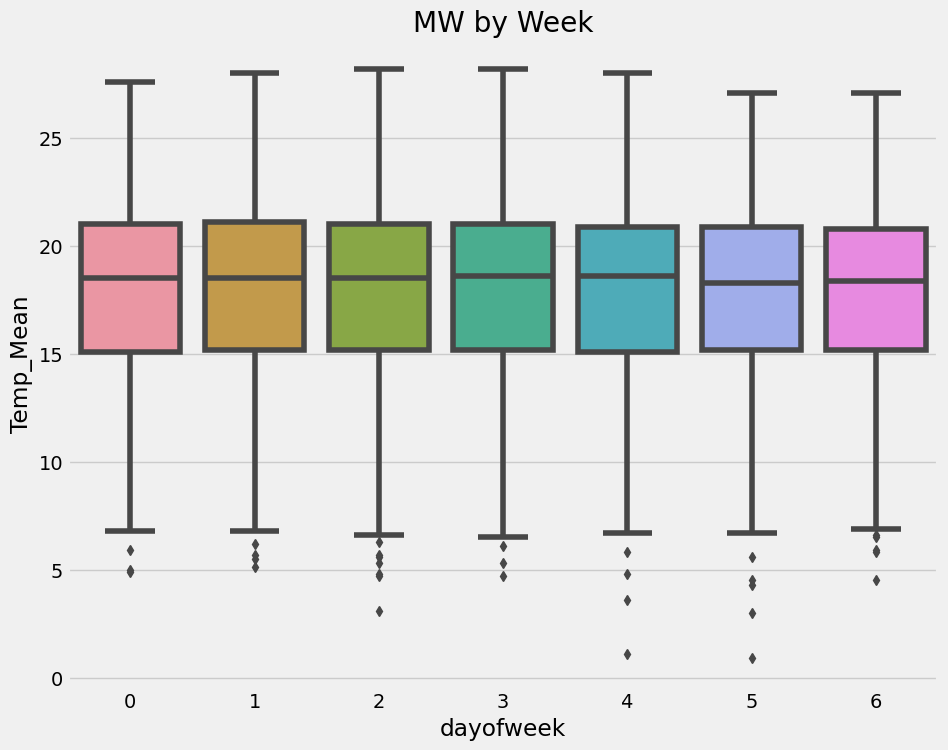

In [57]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='dayofweek', y='Temp_Mean')
ax.set_title('MW by Week')
plt.show()

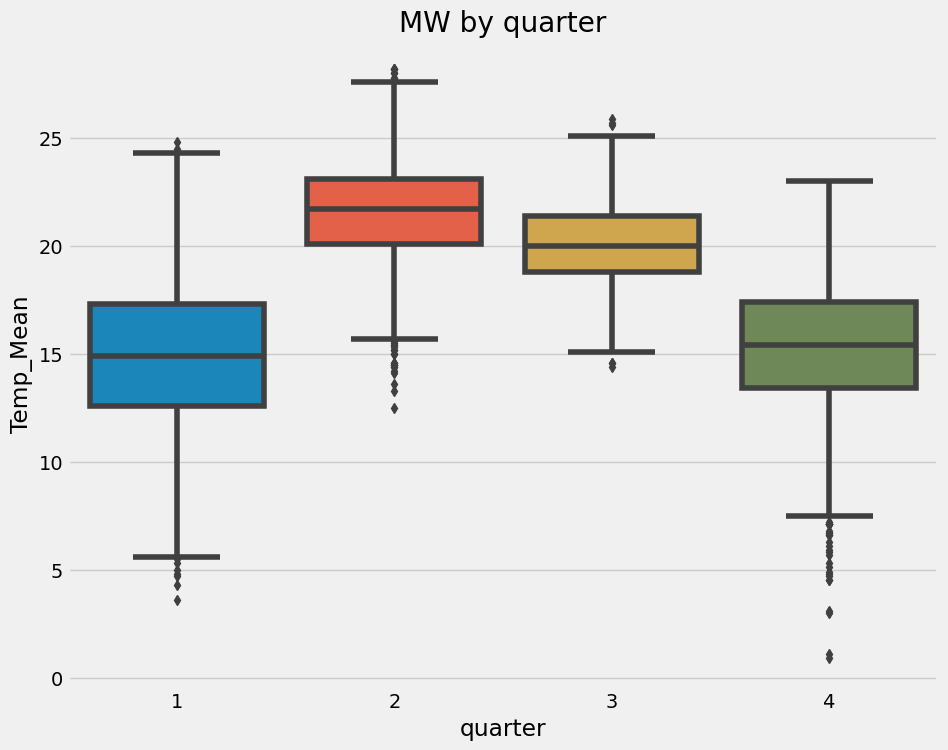

In [58]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='quarter', y='Temp_Mean')
ax.set_title('MW by quarter')
plt.show()

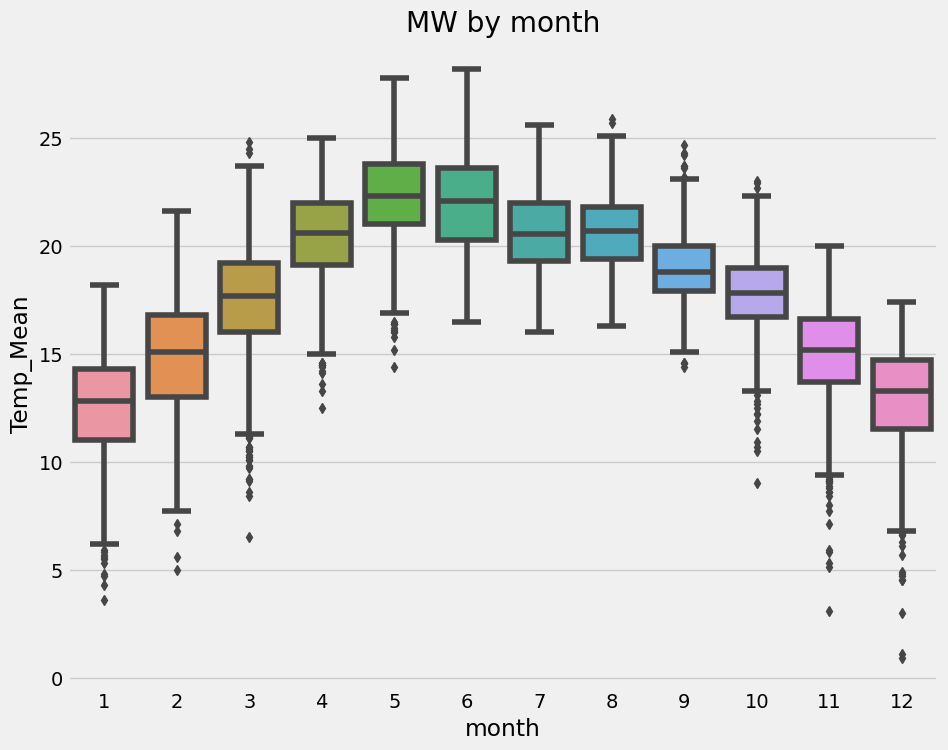

In [59]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='Temp_Mean')
ax.set_title('MW by month')
plt.show()

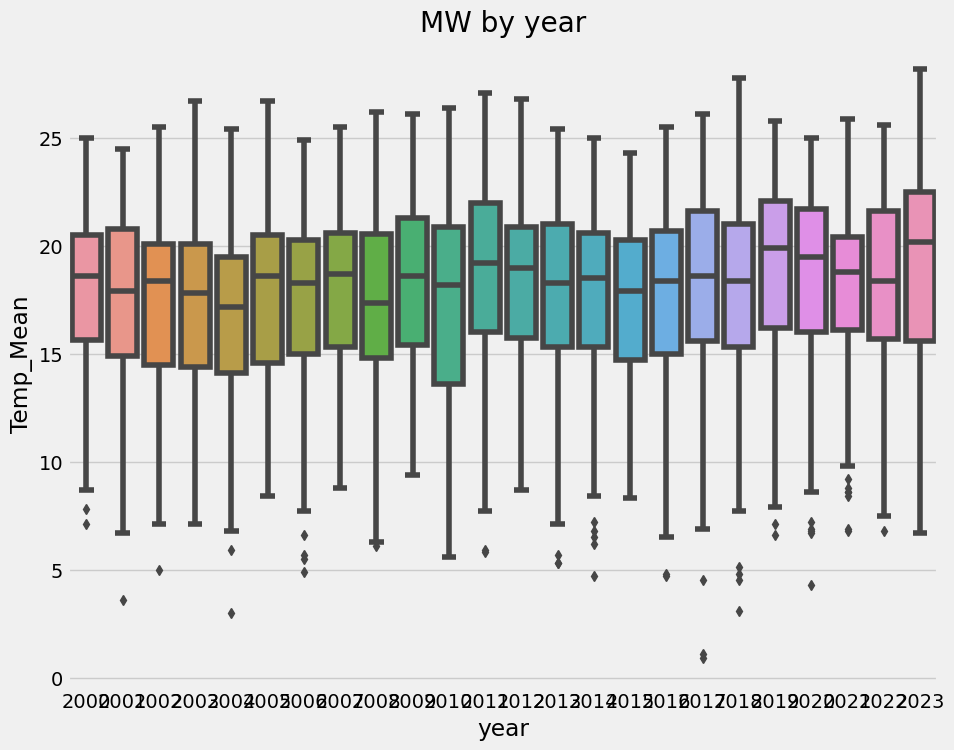

In [60]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='year', y='Temp_Mean')
ax.set_title('MW by year')
plt.show()

# Feature Importance


## Create our Model

In [62]:
train = create_features(train)
test = create_features(test)

In [97]:
df.columns
FEATURES = ['dayofweek',
       'quarter', 'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear']

TARGET = 'Temp_Mean'
X_train = train[FEATURES]
Y_train = train[TARGET]

X_test = test[FEATURES]
Y_test = test[TARGET]

In [111]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, Y_train,
        eval_set=[(X_train, Y_train), (X_test, Y_test)],
        verbose=100)

[0]	validation_0-rmse:17.59824	validation_1-rmse:18.33307
[100]	validation_0-rmse:6.75852	validation_1-rmse:7.42078
[200]	validation_0-rmse:3.13619	validation_1-rmse:3.65731
[300]	validation_0-rmse:2.19853	validation_1-rmse:2.46758
[400]	validation_0-rmse:2.00760	validation_1-rmse:2.24225
[500]	validation_0-rmse:1.95211	validation_1-rmse:2.22825
[516]	validation_0-rmse:1.94753	validation_1-rmse:2.23085


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

# Feature Importance

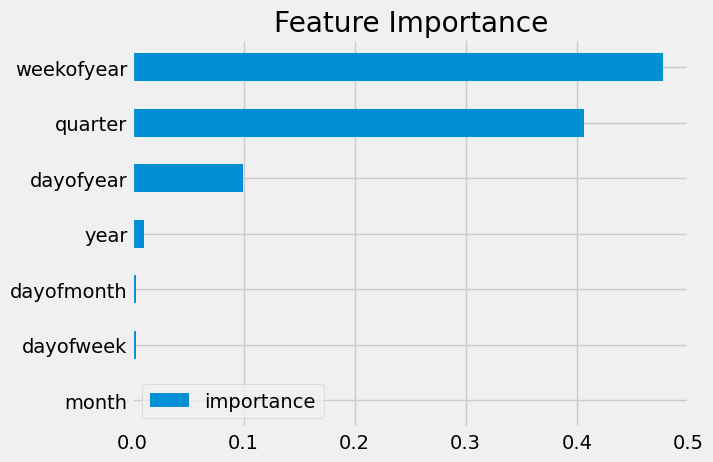

In [112]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

The model gives more importance to the week of year, quarter and day of year.


# Forecast on Test

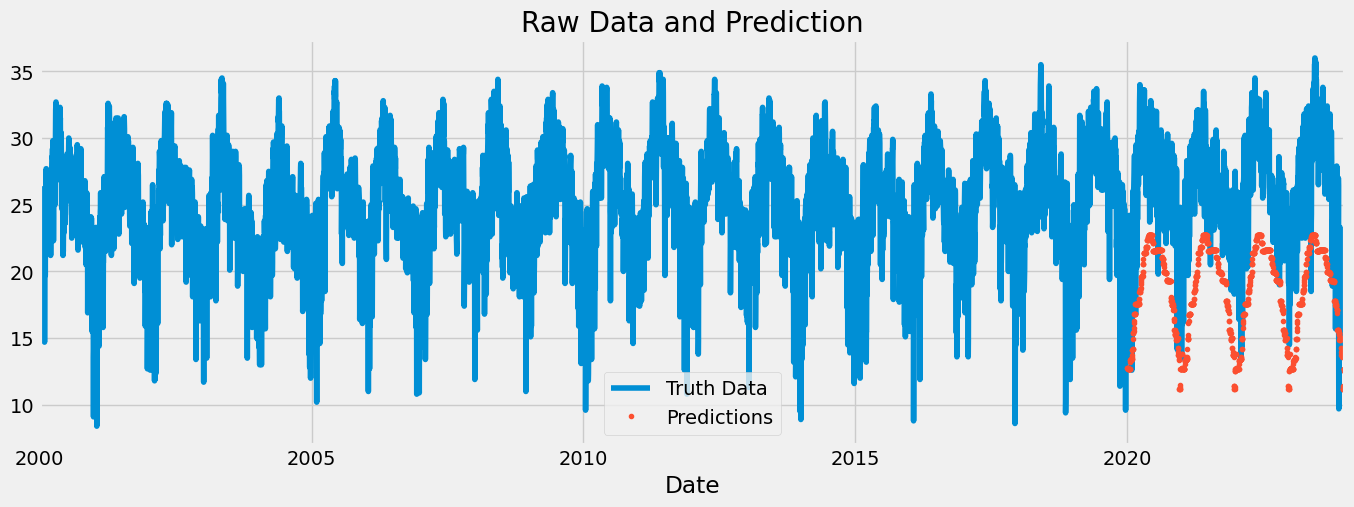

In [114]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)

ax = df[['Temp_Max']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

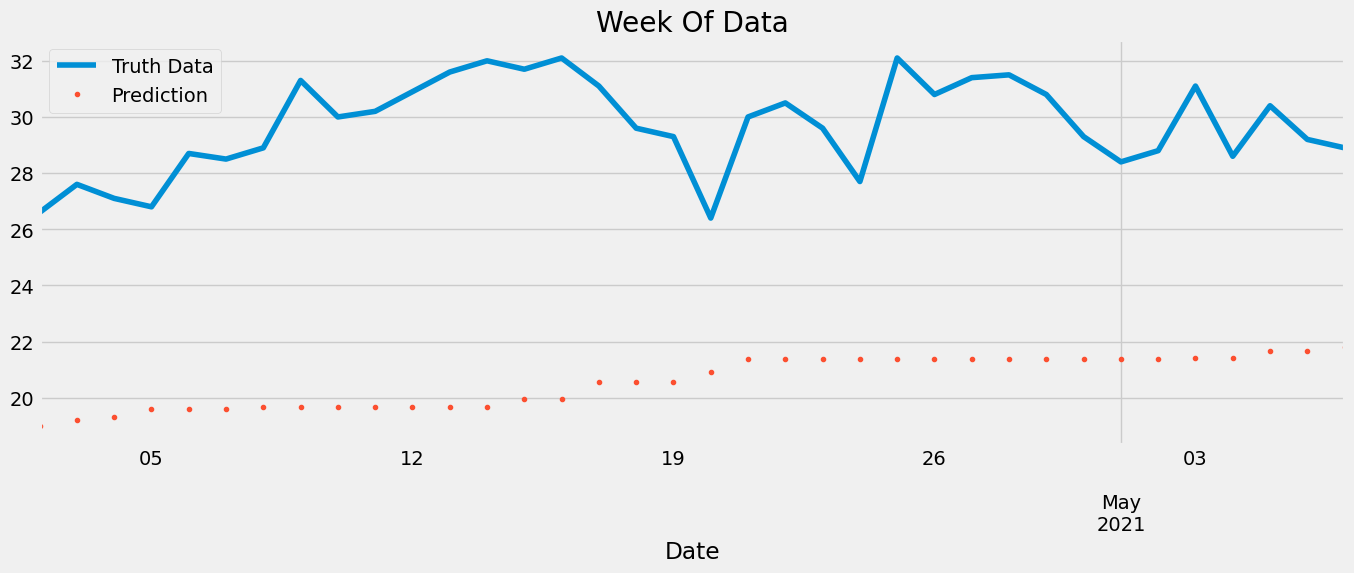

In [119]:
ax = df.loc[(df.index > '04-01-2021') & (df.index < '05-08-2021')]['Temp_Max'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '04-01-2021') & (df.index < '05-08-2021')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

# Score (RMSE)

In [127]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2020-01-04    8.438307
2023-11-22    8.304984
2022-02-08    7.386639
2020-12-06    7.056506
2020-02-27    7.039238
2021-01-02    7.013394
2022-03-24    6.686326
2023-10-31    6.593086
2023-05-20    6.587232
2020-03-25    6.313674
Name: error, dtype: float64